Import Libraries

In [1]:
import os
import time
import json
import pickle
import random
import zipfile
import collections
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

Init base path

In [2]:
m_path = os.path.abspath('')
print('Base path:', m_path)
# Ex: C:\Users\Sami\Faculty of Information Technology\Fifth_Year

Base path: /content


Download Arabic Captions

In [3]:
if not os.path.isfile(m_path + '/ar_captions_train2014.json'):
  print('downloading arabic captions....')
  annotation_file = tf.keras.utils.get_file('ar_captions_train2014.json',
                                            cache_subdir= m_path,
                                            origin='https://github.com/canesee-project/Arabic-COCO/raw/master/ar_captions_train2014.json')
else:
  print('Arabic captions file is already downloaded!')

Arabic captions file is already downloaded!


Download MS-COCO images dataset

In [4]:
if not os.path.isfile(m_path + '/train2014.zip'):
  print('downloading MS-COCO dataset....')
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir= m_path,
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=False)
else:
  print('MS-COCO dataset is already downloaded!')

MS-COCO dataset is already downloaded!


In [5]:
if not os.path.isdir(m_path + '/train2014'):
  print('unzipping dataset.....')
  with zipfile.ZipFile(m_path + '/train2014.zip', 'r') as zip_ref:
    zip_ref.extractall(m_path)

Init Images & annotations dictionary

In [6]:
with open(m_path + '/ar_captions_train2014.json', 'r') as f:
    annotations = json.load(f)

# Group all captions together having the same image ID.
PATH = m_path + '/train2014/'
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

Limit Training Images ($)

In [7]:
image_paths = list(image_path_to_caption.keys())
random.seed(4)
random.shuffle(image_paths)

# train_image_paths = image_paths[:10]
train_image_paths = image_paths
print('training images count:', len(train_image_paths))

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

training images count: 10


Preview an example

<start> فتاة تركض خلف كرة قدم. <end>


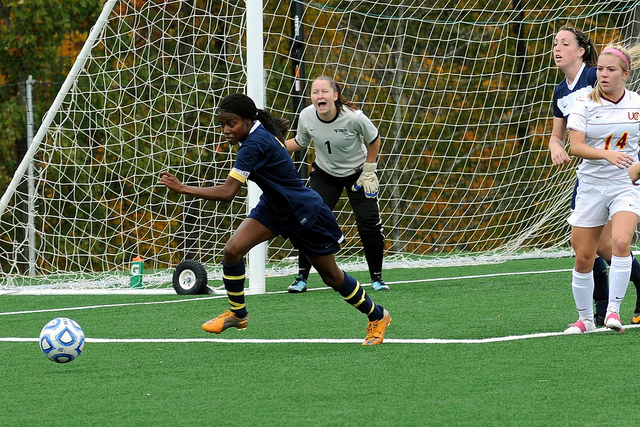

In [8]:
print(train_captions[9])
Image.open(img_name_vector[9])

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

Preprocess the images using InceptionV3

In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

Caching the features extracted from InceptionV3

In [11]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

Tokenize the captions ($)

In [12]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# Choose the top_k words from the vocabulary
top_k = 10000
if os.path.isdir(m_path + '/model_data') and os.path.isfile(m_path + '/model_data/tokenizer.pickle'):
  with open(m_path + '/model_data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    print('Tokenizer is loaded!')
else:
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
  tokenizer.fit_on_texts(train_captions)
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'
  # Saving tokenizer
  if not os.path.isdir(m_path + '/model_data'):
    os.mkdir(m_path + '/model_data')
  with open(m_path + '/model_data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('Tokenizer is saved!')

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print(f'max_length {max_length}')

Tokenizer is saved!
max_length 21


Split the data into training and testing

In [14]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.seed(4)
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

print(f'Train: imgs {len(img_name_train)} | caps {len(cap_train)} | Validation: imgs {len(img_name_val)} | caps {len(cap_val)}')

Train: imgs 40 | caps 40 | Validation: imgs 10 | caps 10


Create a tf.data Dataset for training ($)

In [15]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 128
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [16]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

Datasets(train & validation)

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE, seed=4).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

##########################################################################

dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
dataset_val = dataset_val.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_val = dataset_val.shuffle(BUFFER_SIZE, seed=4).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.AUTOTUNE)

Model

In [18]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [20]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

Saving Model ($)

In [21]:
if os.path.isfile(m_path + '/model_data/encoder.weights') and os.path.isfile(m_path + '/model_data/decoder.weights'):
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)
  encoder.load_weights(m_path + '/model_data/encoder.weights')
  decoder.load_weights(m_path + '/model_data/decoder.weights')
else:
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [23]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Checkpoint ($)

In [24]:
if not os.path.isdir(m_path + '/model_data'):
  os.mkdir(m_path + '/model_data')
checkpoint_path = m_path + "/model_data/checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50)

In [25]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  print(f'last checkpoint {ckpt_manager.latest_checkpoint}')
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)
print('starting from epoch: ', start_epoch)

starting from epoch:  0


Init Training Utils

In [26]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

################

loss_plot_val = []

In [27]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [29]:
@tf.function
def validation_loss(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  return loss, total_loss

Training ($)

In [ ]:
EPOCHS = 35

for epoch in range(start_epoch, EPOCHS):
  start = time.time()
  total_loss = 0

  for (batch, (img_tensor, target)) in enumerate(dataset):
      batch_loss, t_loss = train_step(img_tensor, target)
      total_loss += t_loss

      if batch % 100 == 0:
        average_batch_loss = batch_loss.numpy()/int(target.shape[1])
        print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
  # storing the epoch end loss value to plot later
  loss_plot.append(total_loss / num_steps)

  ###########################################################
  total_loss_val = 0
  
  for (batch, (img_tensor, target)) in enumerate(dataset_val):
    batch_loss_val, t_loss_val = validation_loss(img_tensor, target)
    total_loss_val += t_loss_val
    
    if batch % 100 == 0:
      average_batch_loss_val = batch_loss_val.numpy()/int(target.shape[1])
      print(f'Epoch {epoch+1} Batch {batch} V-Loss {average_batch_loss_val}')
  
  # storing the epoch end validation loss value to plot later
  loss_plot_val.append(total_loss_val / num_steps)
  
  ###########################################################

  # if epoch % 5 == 0:
  ckpt_manager.save()
  encoder.save_weights(m_path + '/model_data/encoder.weights')
  decoder.save_weights(m_path + '/model_data/decoder.weights')
  print(f'checkpoint @ epoch/{epoch}/')

  print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Training loss plot

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.savefig('train loss plot HIGH.png', dpi=600, bbox_inches='tight')

Validation loss plot

In [ ]:
plt.plot(loss_plot_val)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('V-Loss Plot')
plt.savefig('validation loss plot HIGH.png', dpi=600, bbox_inches='tight')

Testing

In [37]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [38]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Test on a validatoin image

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

Test on any image

In [63]:
def predict_url_image(image_url):
  image_name_extension = image_url.split('/')[-1]
  print(image_name_extension)
  image_path = tf.keras.utils.get_file(image_name_extension, origin=image_url, cache_subdir='/content')
  result, attention_plot = evaluate(image_path)
  return image_path, result, attention_plot

In [ ]:
url = 'https://ichef.bbci.co.uk/news/873/cpsprodpb/2F0D/production/_118054021_1afcbf08-6b32-4d75-9cca-783d61d7b94f.jpg'
image_path, result, attention_plot = predict_url_image(url)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)